# Segmentation Model

In [2]:
# Prerequisites
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from segmentation_dataset import SegmentationDataset
import segmentation_models_pytorch as smp 



### Check Running Environment

In [3]:
# Check if notebook being run in Colab or locally  
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False
print (f'Running in Colab: {IN_COLAB}')

# Check if GPU is available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using ", DEVICE)

Running in Colab: False
Using  cuda


### Set Hyperparameters

In [4]:
NR_EPOCHS = 50
BATCH_SIZE = 4

### Set 'train' and 'val' Datasets & Dataloaders

In [5]:
if IN_COLAB:
    pass
else:
    train_data_path = "data/processed/train"
    val_data_path = "data/processed/val"
    test_data_path = "data/processed/test"


train_dataset = SegmentationDataset(path_name=train_data_path)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = SegmentationDataset(path_name=val_data_path)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

### Define Model

In [6]:
model = smp.FPN( #  Feature Pyramid Network
    encoder_name = "se_resnext50_32x4d", # Encoder - ResNeXt-50
    encoder_weights="imagenet", # Pretrained weights for encoder
    classes=6, # Number of output classes
    activation="sigmoid" #
) 

model.to(DEVICE)   # Move model to GPU if available

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) # Adam optimizer

criterion = nn.CrossEntropyLoss() # Cross-entropy loss
# criterion = smp.losses.DiceLoss(mode='multiclass') # Dice loss

### Training Loop

In [7]:
train_losses = []
val_losses = []

for epoch in range(NR_EPOCHS):

    # Training Phase
    model.train()
    running_train_loss = 0
    running_val_loss = 0

    for i, data in enumerate(train_dataloader):
        image_i, mask_i = data
        image = image_i.to(DEVICE)
        mask = mask_i.to(DEVICE)

        # Reset gradients
        optimizer.zero_grad()

        # Forward Pass
        output = model(image.float())

        # Calculate losses
        train_loss = criterion(output.float(), mask.long())

        # Back propagation
        train_loss.backward()
        optimizer.step()  # Update weights

        running_train_loss += train_loss.item()

    train_losses.append(running_train_loss)

    # Validation Phase
    model.eval()
    for i, data in enumerate(val_dataloader):
        image_i, mask_i = data
        image = image_i.to(DEVICE)
        mask = mask_i.to(DEVICE)

        # Forward Pass
        output = model(image.float())

        # Calculate losses
        val_loss = criterion(output.float(), mask.long())
        running_val_loss += val_loss.item()

    val_losses.append(running_val_loss)

    print(f"Epoch: {epoch}: Train Loss: {np.median(running_train_loss)}, Val Loss: {np.median(running_val_loss)}")


Epoch: 0: Train Loss: 214.46812903881073, Val Loss: 10.76847529411316
Epoch: 1: Train Loss: 194.35522317886353, Val Loss: 10.667044043540955
Epoch: 2: Train Loss: 188.64822936058044, Val Loss: 10.707909226417542
Epoch: 3: Train Loss: 185.11022865772247, Val Loss: 10.671605944633484
Epoch: 4: Train Loss: 183.44579899311066, Val Loss: 10.64606761932373
Epoch: 5: Train Loss: 182.3572587966919, Val Loss: 10.604496359825134
Epoch: 6: Train Loss: 182.17431473731995, Val Loss: 11.186429619789124
Epoch: 7: Train Loss: 181.29984366893768, Val Loss: 10.574872136116028
Epoch: 8: Train Loss: 179.94841587543488, Val Loss: 10.55919361114502
Epoch: 9: Train Loss: 179.0969077348709, Val Loss: 10.558289289474487
Epoch: 10: Train Loss: 178.6828899383545, Val Loss: 10.54019844532013
Epoch: 11: Train Loss: 178.28325879573822, Val Loss: 10.573320031166077
Epoch: 12: Train Loss: 177.8848956823349, Val Loss: 10.596218228340149
Epoch: 13: Train Loss: 177.5734270811081, Val Loss: 10.526920437812805
Epoch: 14: 

### Visualize

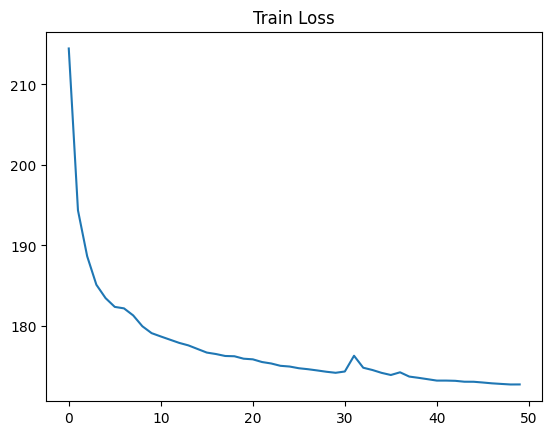

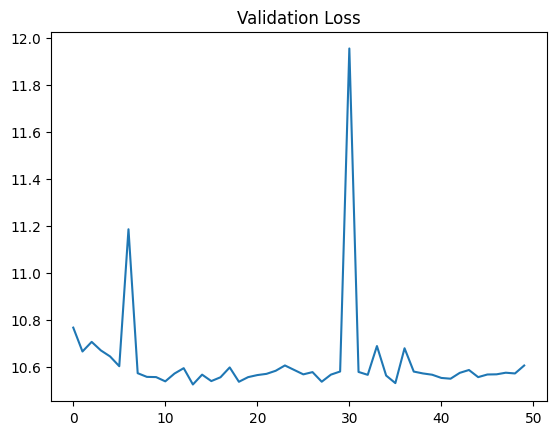

In [8]:
sns.lineplot(x = range(len(train_losses)), y= train_losses).set(title='Train Loss')
plt.show()
sns.lineplot(x = range(len(train_losses)), y= val_losses).set(title='Validation Loss')
plt.show()

### Save Model

In [9]:
torch.save(model.state_dict(), f'models/FPN_epochs_{NR_EPOCHS}_crossentropy_state_dict.pth')